In [1]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import os
import sys
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,Multiply,Add
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

2021-12-03 14:52:02.095411: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-03 14:52:02.095457: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Set some parameters
im_width = 256
im_height = 256
path_train = 'IndoorRSSINet_Dataset/'

In [3]:
# Get and resize train images and masks
def get_data(path, train=True):
    ids = next(os.walk(path + "Transmitter_position_Image"))[2]
    ids=sorted(ids)
    ids2= next(os.walk(path + "RSSI_data"))[2]
    ids2=sorted(ids2)
    X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    Lay = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        # Load images
        img = load_img(path + '/Transmitter_position_Image/' + id_, grayscale=True)
        x_img = img_to_array(img)
        x_img = resize(x_img, (im_height, im_width, 1),anti_aliasing=False, order=0, mode='constant', preserve_range=True)
        x_img_max=np.amax(x_img)
        x_img_min=np.amin(x_img)
        
        layout = load_img(path + '/Room_plan/' + id_, grayscale=True)
        layout_img = img_to_array(layout)
        layout_img = resize(layout_img, (im_height, im_width, 1),anti_aliasing=False, order=0, mode='constant', preserve_range=True)
        layout_img_max = np.amax(layout_img)
        layout_img_min = np.amin(layout_img)   
        
        # Load masks
        if train:
            heatmap = pd.read_csv(path + '/RSSI_data/' + ids2[n])
            heatmap = heatmap.to_numpy()
            heatmap = resize(heatmap, (im_height, im_width, 1),anti_aliasing=False, order=0, mode='constant', preserve_range=True)
        
        # Save images
        X[n, ..., 0] = ((x_img - x_img_min) / (x_img_max - x_img_min)).squeeze()
        heatmap_max = np.amax(heatmap)
        heatmap_min = np.amin(heatmap)
        
        Lay[n, ..., 0] = ((layout_img - layout_img_min) / (layout_img_max - layout_img_min)).squeeze()
        if train:
            y[n] = ((heatmap-heatmap_min)/(heatmap_max - heatmap_min))**2  
    print('Done!')
    
    if train:
        return X, Lay, y
    else:
        return X,Lay
    
X, Lay, y = get_data(path_train, train=True)

Getting and resizing images ... 


/tmp/ipykernel_3473/1034834181.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):


  0%|          | 0/201 [00:00<?, ?it/s]

/home/nibin/anaconda3/lib/python3.9/site-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Done!


In [4]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2018)
X_train, X_valid, Lay_train, Lay_valid = train_test_split(X, Lay, test_size=0.15, random_state=2018)

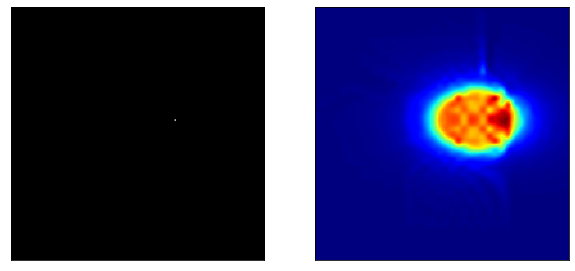

In [5]:

ix = random.randint(0, len(X_train)); 
has_mask = y_train[ix].max() > 0
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(X_train[ix, ..., 0],interpolation='bilinear',cmap='gray')

a=ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='jet')
ax[0].grid(False)
# Hide axes ticks
ax[0].set_xticks([]);
ax[0].set_yticks([]);

ax[1].grid(False)
# Hide axes ticks
ax[1].set_xticks([]);
ax[1].set_yticks([]);

In [6]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
#     second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
#     third layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
# #     4th layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x


In [7]:
def get_rssinet1(input_img, n_filters=8, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    #bottleneck
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    #Expanding path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

# Training the RSSINET-I

In [8]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_rssinet1(input_img, n_filters=8, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="mean_squared_error", metrics=["mae"])
model.summary()

2021-12-03 14:52:13.484354: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-03 14:52:13.484434: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-12-03 14:52:13.484479: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-12-03 14:52:13.484524: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2021-12-03 14:52:13.484569: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  80          ['img[0][0]']                    
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [9]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('RSSINet_I.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [10]:
#Training section RSSINET-I
# results = model.fit(X_train, y_train, batch_size=4, epochs =1500, callbacks=callbacks,
#                     validation_data=(X_valid, y_valid))

In [11]:
# Load best model
model.load_weights('RSSINet_I.h5')

In [12]:
# Evaluate on validation set 
model.evaluate(X_valid, y_valid, verbose=1)
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

1/1 [==============================] - 1s 949ms/step


In [13]:
def plot_funct(X, y, preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))
    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(10, 10))
    ax[0].imshow(X[ix, ..., 0],interpolation='bilinear',cmap='gray')
    # Hide axes ticks
    ax[0].set_xticks([]);
    ax[0].set_yticks([]);

    A=ax[1].imshow(y[ix].squeeze(),cmap='jet');
    ax[1].set_xticks([]); 
    ax[1].set_yticks([]);

    
    B=ax[2].imshow(preds[ix].squeeze(),cmap='jet')
    ax[2].set_xticks([]); 
    ax[2].set_yticks([]);

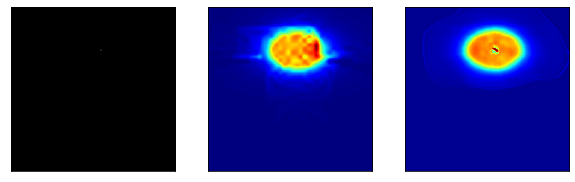

In [14]:
plot_funct(X_train, y_train, preds_train, ix=1)

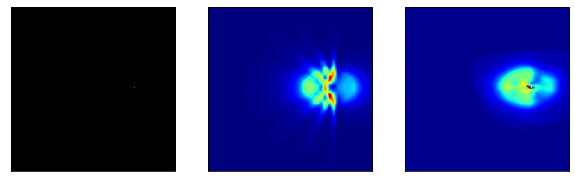

In [15]:
plot_funct(X_valid, y_valid, preds_val,ix=1);

# MSE  for RSSINET-I

In [16]:
mse_train = ((y_train - preds_train)**2).mean()
print('mse_train  = %.16f' %(mse_train))

mse_valid = ((y_valid - preds_val)**2).mean()
print('mse_valid  = %.16f' %(mse_valid))

mse_train  = 0.0018735998310149
mse_valid  = 0.0029242143500596


# Training of RSSINET-II 

In [17]:
def get_rssinet2(input_,layout_image, n_filters=8, dropout=0.5, batchnorm=True):
    # contracting path
    M1_1 = Multiply()([input_,layout_image,])
    
    c1 = conv2d_block(M1_1, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    #bottleneck
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    #Expanding path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1),  activation='sigmoid') (c9)
    model = Model(inputs=[input_img,layout_image], outputs=[outputs])
    return model

In [18]:
input_ = Input((im_height, im_width, 1), name='img_')
layout_image = Input((im_height, im_width, 1), name='layout')
model2 = get_rssinet2(input_img,layout_image, n_filters=8, dropout=0.05, batchnorm=True)
model2.compile(optimizer=Adam(), loss="mean_squared_error", metrics=["mae"])
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 layout (InputLayer)            [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 multiply (Multiply)            (None, 256, 256, 1)  0           ['img[0][0]',                    
                                                                  'layout[0][0]']           

In [19]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('RSSINET_II.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [20]:
layer1_pred = model.predict(X_train)
modified_ytrain = np.zeros(X_train.shape)
for i in range(X_train.shape[0]):
    modified_ytrain[i,:,:,:] = y_train[i,:,:,:] - layer1_pred[i,:,:,:]

In [21]:
layer1_pred_valid = model.predict(X_valid)
modified_yvalid = np.zeros(X_valid.shape)
for i in range(X_valid.shape[0]):
    modified_yvalid[i,:,:,:] = y_valid[i,:,:,:] - layer1_pred_valid[i,:,:,:]

In [22]:
#Training section RSSINET-II
# results2 = model2.fit([layer1_pred, Lay_train], modified_ytrain, batch_size=4, epochs=1500, callbacks=callbacks,
#                     validation_data=([layer1_pred_valid, Lay_valid], modified_yvalid))

In [23]:
# Load best model
model2.load_weights('RSSINET_II.h5')

In [24]:
# Evaluate on validation set 
model2.evaluate([layer1_pred_valid, Lay_valid],modified_yvalid, verbose=1)

# Predict on train, val and test
preds_train2 = model2.predict([layer1_pred,Lay_train], verbose=1)
preds_val2 = model2.predict([layer1_pred_valid, Lay_valid], verbose=1)


1/1 [==============================] - 1s 879ms/step


In [25]:
def plot_funct2(X, y, preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))
    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(10, 10))
    ax[0].imshow(X[ix, ..., 0],interpolation='bilinear',cmap='jet')
    # Hide axes ticks
    ax[0].set_xticks([]);
    ax[0].set_yticks([]);

    A=ax[1].imshow((y[ix].squeeze()),cmap='jet');
    ax[1].set_xticks([]); 
    ax[1].set_yticks([]);

    
    B=ax[2].imshow((preds[ix].squeeze()),cmap='jet')
    ax[2].set_xticks([]); 
    ax[2].set_yticks([]);

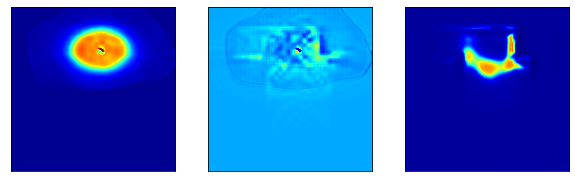

In [26]:
plot_funct2(layer1_pred, modified_ytrain, preds_train2, ix=1)

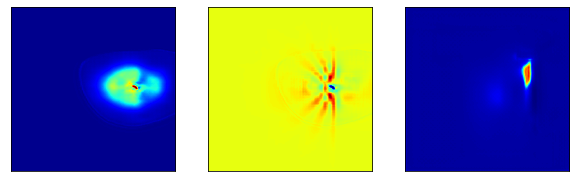

In [27]:
plot_funct2(layer1_pred_valid, modified_yvalid, preds_val2,ix=1);

# MSE for RSSINET-II

In [28]:
mse_train2 = ((modified_ytrain - preds_train2)**2).mean()
print('mse_train  = %.16f' %(mse_train2))

mse_valid2 = ((modified_yvalid - preds_val2)**2).mean()
print('mse_valid  = %.16f' %(mse_valid2))

mse_train  = 0.0019546342813773
mse_valid  = 0.0029822369289142


# Final Concatenation + Dense

In [29]:
u1 = layer1_pred
v1 = layer1_pred_valid

In [30]:
u2 = model2.predict([u1,Lay_train], verbose=1)
v2 = model2.predict([v1,Lay_valid], verbose=1)

1/1 [==============================] - 1s 1s/step


In [31]:
def final_model(out1,out2):
    c1= concatenate([out1, out2], axis=3)
    d1= Dense(1)(c1)
    model = Model(inputs=[out1,out2], outputs=[d1])
    return model

In [32]:
out1 = Input((im_height, im_width, 1), name='out1')
out2 = Input((im_height, im_width, 1), name='out2')
model4 = final_model(out1, out2)
model4.compile(optimizer=Adam(), loss="mean_squared_error", metrics=["mae"])
model4.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 out1 (InputLayer)              [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 out2 (InputLayer)              [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_8 (Concatenate)    (None, 256, 256, 2)  0           ['out1[0][0]',                   
                                                                  'out2[0][0]']             

In [33]:
callbacks1 = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('Final_concat.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [34]:
# Training section Final Concateanation + dense layer
# results4 = model4.fit([u1,u2], y_train, batch_size=4, epochs=2500, callbacks=callbacks1,
#                     validation_data=([v1,v2], y_valid))

In [35]:
# Load best model
model4.load_weights('Final_concat.h5')

In [36]:
# Evaluate on validation set 
model4.evaluate([v1, v2], y_valid, verbose=1)

# Predict on train, val and test
preds_train4 = model4.predict([u1,u2], verbose=1)
preds_val4 = model4.predict([v1,v2], verbose=1)

1/1 [==============================] - 0s 34ms/step


In [37]:
def plot_funct3(X, y, preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))
    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(10, 10))
    ax[0].imshow(X[ix, ..., 0],interpolation='bilinear',cmap='jet')
    # Hide axes ticks
    ax[0].set_xticks([]);
    ax[0].set_yticks([]);

    A=ax[1].imshow(y[ix].squeeze(),cmap='jet');
    ax[1].set_xticks([]); 
    ax[1].set_yticks([]);

    
    B=ax[2].imshow(preds[ix].squeeze(),cmap='jet')
    ax[2].set_xticks([]); 
    ax[2].set_yticks([]);

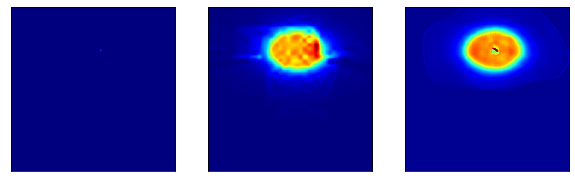

In [38]:
plot_funct3(X_train, y_train, preds_train4, ix=1)

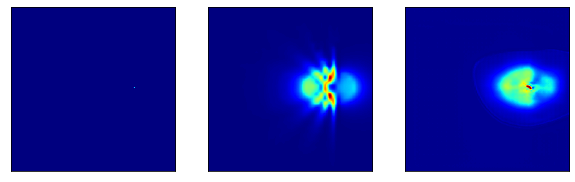

In [39]:
plot_funct3(X_valid, y_valid, preds_val4,ix=1);

# MSE for Final Model

In [47]:
mse_train4 = ((y_train - preds_train4)**2).mean()
print('mse train  = %.16f' %(mse_train4))
rmse_train = np.sqrt(mse_train4)
print('rmse train =' ,rmse_train)

mse_valid4 = ((y_valid - preds_val4)**2).mean()
print('mse valid  = %.16f' %(mse_valid4))
rmse_valid = np.sqrt(mse_valid4)
print('rmse valid =' ,rmse_valid)

mse train  = 0.0012915091356263
rmse train = 0.035937574
mse valid  = 0.0024243285879493
rmse valid = 0.04923747


(array([5.2866e+04, 3.5770e+03, 1.5160e+03, 9.2800e+02, 7.6300e+02,
        5.5700e+02, 4.5800e+02, 3.8300e+02, 3.0500e+02, 2.9500e+02,
        2.5600e+02, 2.4900e+02, 2.8000e+02, 6.5400e+02, 1.4900e+03,
        5.3900e+02, 2.1200e+02, 9.9000e+01, 7.1000e+01, 3.8000e+01]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ],
       dtype=float32),
 <BarContainer object of 20 artists>)

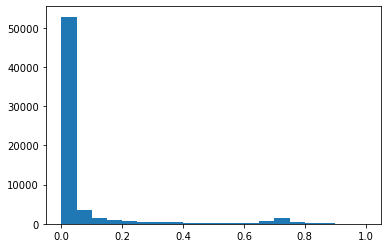

In [48]:
hist_data = y_train[1].flatten()
plt.hist(hist_data,20)